In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import networkx as nx
import plotly.graph_objects as go

import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import plotly.io as pio

In [3]:
#xlsx_path = './240906_이연희교수님_correlation_data.xlsx'
xlsx_path = './Data/241013_Chronic and VAS (visualization).xlsx'

In [5]:
df = pd.read_excel(xlsx_path).dropna()

df.rename(columns={'Acute0Chronic1': 'Chronic TMD', 'STOP-Bang 3': 'STOP-Bang>=3', 'STOP-Bang 5': 'STOP-Bang>=5', 'SEX_M1F2' : 'Female'}, inplace=True)

df = df.drop(columns=['ID'])
df.columns
df

,Chronic TMD,VAS,Female,Age,Sleep time,TMJ noise,TMD pain,Locking,Mucle stiffness,Bruxism,Macrotrauma,Tinnitus,Psychological distress,Sleep problem,ADD,TMJ OA,Effusion,Joint space narrowing,STOP-Bang>=3,STOP-Bang>=5
0,0,1,2,46,7.0,0,1,0,0.0,0,0,1,1,1,1,1,0,1,0,0
1,0,2,2,37,7.5,1,0,0,0.0,0,0,1,0,0,1,1,1,1,0,0
2,0,4,1,51,9.0,0,1,0,0.0,0,0,1,1,0,1,1,1,1,1,0
3,0,7,2,29,7.0,0,1,1,0.0,0,0,1,1,0,1,1,1,1,1,0
4,0,3,2,55,9.0,1,0,0,0.0,0,0,0,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,1,7,2,49,6.0,0,1,1,1.0,0,0,0,0,0,1,0,0,1,0,0
234,1,3,1,28,6.0,0,1,1,0.0,0,0,0,0,0,1,0,1,1,1,1
235,1,2,2,14,8.0,1,0,1,0.0,0,0,0,1,0,1,1,1,1,1,1
237,1,3,1,22,11.0,1,1,1,0.0,0,0,1,1,1,1,1,1,1,1,1


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## Logistic Regression

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Seed 고정
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # for reproducibility
    torch.backends.cudnn.benchmark = False

# 시드 고정 (예: 42)
set_seed(42)

# 데이터 로드 및 전처리 (예시)
X = df.drop(columns=['Chronic TMD']).values
y = df['Chronic TMD'].values

# 데이터 정규화 (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# NumPy 배열을 Tensor로 변환
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# train:test = 8:2 split
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 설정 (batch_size는 예시로 64)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Logistic Regression 모델 정의
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Logistic regression은 단일 노드 출력
        self.sigmoid = nn.Sigmoid()  # 이진 분류용 활성화 함수
    
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# 모델, 손실 함수, 최적화 도구 설정
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')  # CUDA 1번 사용
model_logistic = LogisticRegressionModel(input_size=X_tensor.shape[1]).to(device)  # 변수명 수정
criterion = nn.BCELoss()  # 이진 분류용 손실 함수
optimizer = optim.Adam(model_logistic.parameters(), lr=0.05)

# 학습 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()  # 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)  # label을 float으로 변경
            
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')

# 테스트 함수
def test_model(model, test_loader):
    model.eval()  # 평가 모드로 설정
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()  # 0.5 이상이면 1, 그렇지 않으면 0으로 예측
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {test_accuracy:.4f}')

# 모델 학습
train_model(model_logistic, train_loader, criterion, optimizer, num_epochs=100)

# 테스트 성능 평가
test_model(model_logistic, test_loader)


Epoch [1/100], Loss: 2.0087
Epoch [2/100], Loss: 1.6914
Epoch [3/100], Loss: 1.5266
Epoch [4/100], Loss: 1.4872
Epoch [5/100], Loss: 1.4777
Epoch [6/100], Loss: 1.4630
Epoch [7/100], Loss: 1.4549
Epoch [8/100], Loss: 1.4359
Epoch [9/100], Loss: 1.4356
Epoch [10/100], Loss: 1.4303
Epoch [11/100], Loss: 1.4231
Epoch [12/100], Loss: 1.4274
Epoch [13/100], Loss: 1.4307
Epoch [14/100], Loss: 1.4344
Epoch [15/100], Loss: 1.4239
Epoch [16/100], Loss: 1.4251
Epoch [17/100], Loss: 1.4245
Epoch [18/100], Loss: 1.4278
Epoch [19/100], Loss: 1.4262
Epoch [20/100], Loss: 1.4285
Epoch [21/100], Loss: 1.4269
Epoch [22/100], Loss: 1.4253
Epoch [23/100], Loss: 1.4218
Epoch [24/100], Loss: 1.4231
Epoch [25/100], Loss: 1.4367
Epoch [26/100], Loss: 1.4229
Epoch [27/100], Loss: 1.4228
Epoch [28/100], Loss: 1.4224
Epoch [29/100], Loss: 1.4229
Epoch [30/100], Loss: 1.4257
Epoch [31/100], Loss: 1.4283
Epoch [32/100], Loss: 1.4247
Epoch [33/100], Loss: 1.4271
Epoch [34/100], Loss: 1.4217
Epoch [35/100], Loss: 1

## DNN

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Seed 고정 함수
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # for reproducibility
    torch.backends.cudnn.benchmark = False

# 시드 고정 (예: 42)
set_seed(42)

# 데이터 로드 및 전처리 (예시)
# df = pd.read_csv('your_data.csv')
X = df.drop(columns=['Chronic TMD']).values
y = df['Chronic TMD'].values

# 데이터 정규화 (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# NumPy 배열을 Tensor로 변환
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# train:val:test = 0.6:0.2:0.2 split
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader 설정 (batch_size는 예시로 64)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 신경망 모델 정의
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)  # 이진 분류니까 출력 노드는 2
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.fc5(x)  # 마지막에는 활성화 함수 없음 (CrossEntropyLoss가 softmax 적용함)
        return x

# 모델, 손실 함수, 최적화 도구 설정
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')  # CUDA 1번 사용
model_mlp = MLPModel(input_size=X_tensor.shape[1]).to(device)  # 변수명 수정
criterion = nn.CrossEntropyLoss()  # 이진 분류용 손실 함수
optimizer = optim.Adam(model_mlp.parameters(), lr=0.0005)

# 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_val_loss = float('inf')  # 초기화
    best_model_wts = None  # 최적 모델의 가중치 저장 변수
    model.train()  # 학습 모드로 설정

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        
        # Validation loss가 가장 낮을 때 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()  # 최적 모델의 가중치 저장

    # 학습 완료 후 최적 모델의 가중치 로드
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print("Best model loaded with Val Loss: {:.4f}".format(best_val_loss))
    return best_model_wts  # best_model_wts 반환

# 검증 함수
def validate_model(model, val_loader, criterion):
    model.eval()  # 평가 모드로 설정
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy

# 테스트 함수 (best model로 수행)def test_model(model, test_loader):
    model.eval()  # 평가 모드로 설정
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {test_accuracy:.4f}')

# 테스트 함수 (best model로 수행)
def test_model(model, test_loader):
    model.eval()  # 평가 모드로 설정
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 리스트를 numpy 배열로 변환
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Accuracy 계산
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {test_accuracy:.4f}')

# 모델 학습
best_model_wts = train_model(model_mlp, train_loader, val_loader, criterion, optimizer, num_epochs=100)

# 테스트 성능 평가 (best model로)
test_model(model_mlp, test_loader)

Epoch [1/100], Loss: 2.0905, Val Loss: 0.6860, Val Accuracy: 0.6170
Epoch [2/100], Loss: 2.0902, Val Loss: 0.6861, Val Accuracy: 0.6170
Epoch [3/100], Loss: 2.0815, Val Loss: 0.6864, Val Accuracy: 0.6383
Epoch [4/100], Loss: 2.0610, Val Loss: 0.6868, Val Accuracy: 0.6809
Epoch [5/100], Loss: 2.0568, Val Loss: 0.6869, Val Accuracy: 0.6170
Epoch [6/100], Loss: 2.0463, Val Loss: 0.6868, Val Accuracy: 0.5957
Epoch [7/100], Loss: 2.0279, Val Loss: 0.6870, Val Accuracy: 0.5319
Epoch [8/100], Loss: 2.0270, Val Loss: 0.6875, Val Accuracy: 0.5319
Epoch [9/100], Loss: 2.0081, Val Loss: 0.6868, Val Accuracy: 0.5319
Epoch [10/100], Loss: 1.9681, Val Loss: 0.6854, Val Accuracy: 0.5319
Epoch [11/100], Loss: 1.9352, Val Loss: 0.6844, Val Accuracy: 0.5319
Epoch [12/100], Loss: 1.9486, Val Loss: 0.6826, Val Accuracy: 0.5532
Epoch [13/100], Loss: 1.9185, Val Loss: 0.6803, Val Accuracy: 0.5319
Epoch [14/100], Loss: 1.9165, Val Loss: 0.6774, Val Accuracy: 0.5319
Epoch [15/100], Loss: 1.8754, Val Loss: 0.6

## Comparison

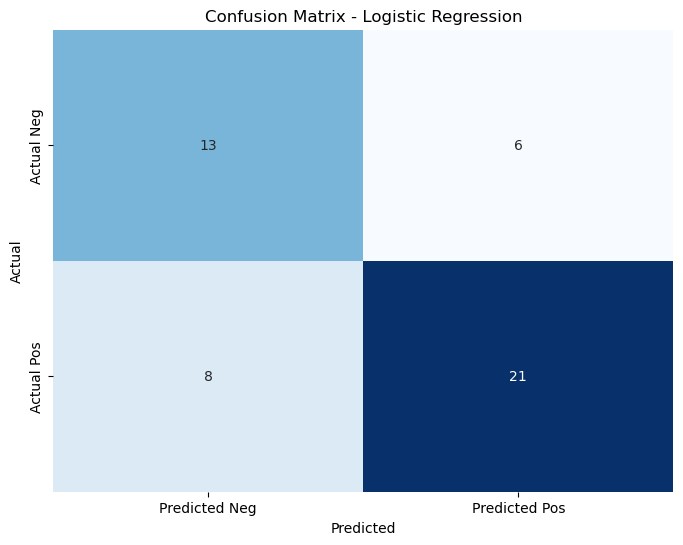

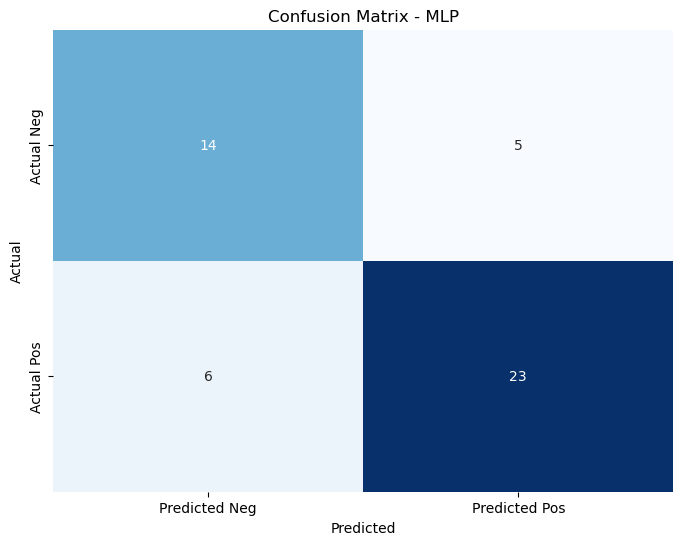

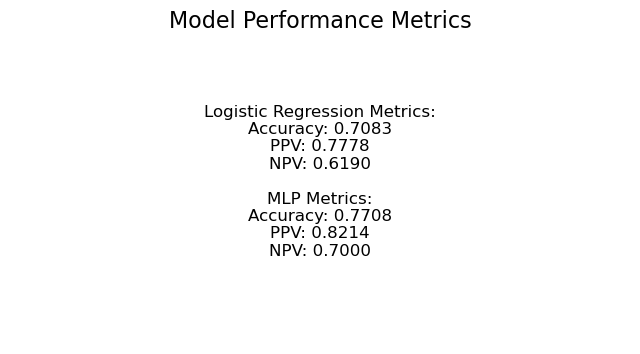

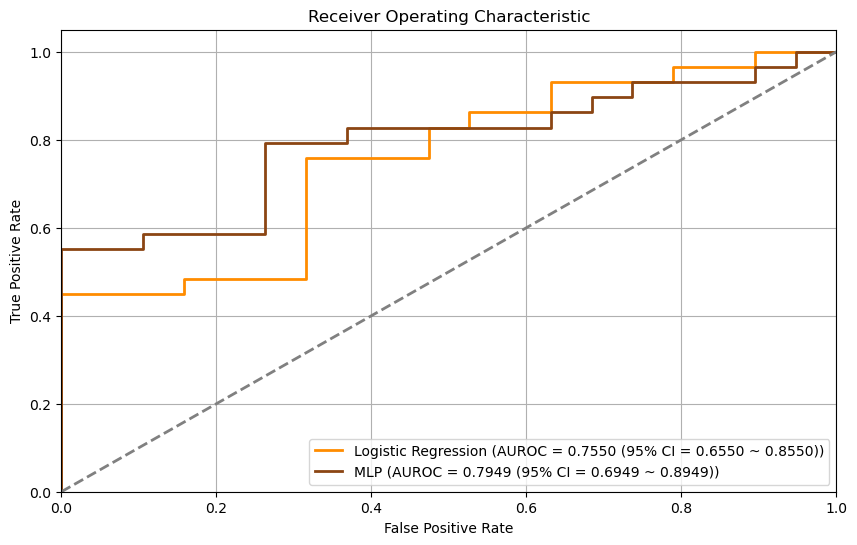

Logistic Regression AUROC: 0.7550
MLP AUROC: 0.7949
DeLong's Test p-value: 0.3067


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torch
import numpy as np
from scipy import stats

# Helper function to compute additional metrics
def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    return accuracy, ppv, npv, tn, fp, fn, tp

# Get predictions for the test set
# Assuming test_dataset is a Subset object derived from a larger TensorDataset
original_dataset = test_dataset.dataset  # Get the original TensorDataset
test_indices = test_dataset.indices  # Get the indices of the test set

# Extract test set features and labels directly from TensorDataset
X_test_tensor = original_dataset.tensors[0][test_indices].to(device)  # Features
y_test = original_dataset.tensors[1][test_indices].cpu().numpy()  # Labels

# Logistic Regression predictions
y_pred_logistic = (model_logistic(X_test_tensor).squeeze().cpu().detach().numpy() > 0.5).astype(int)

# MLP predictions
model_mlp.load_state_dict(best_model_wts)  # Load best MLP model
model_mlp.eval()  # Set the model to evaluation mode
y_pred_mlp = torch.argmax(model_mlp(X_test_tensor), dim=1).cpu().numpy()

# Compute metrics for both models
accuracy_logistic, ppv_logistic, npv_logistic, tn_logistic, fp_logistic, fn_logistic, tp_logistic = compute_metrics(y_test, y_pred_logistic)
accuracy_mlp, ppv_mlp, npv_mlp, tn_mlp, fp_mlp, fn_mlp, tp_mlp = compute_metrics(y_test, y_pred_mlp)

# Confusion Matrices
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logistic, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Neg', 'Predicted Pos'], yticklabels=['Actual Neg', 'Actual Pos'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot Confusion Matrix for MLP
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Neg', 'Predicted Pos'], yticklabels=['Actual Neg', 'Actual Pos'])
plt.title('Confusion Matrix - MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# AUROC Curve
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, model_logistic(X_test_tensor).squeeze().cpu().detach().numpy())
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, torch.softmax(model_mlp(X_test_tensor), dim=1)[:, 1].cpu().detach().numpy())
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Print formatted metrics
metrics_text = (
    f"Logistic Regression Metrics:\n"
    f"Accuracy: {accuracy_logistic:.4f}\n"
    f"PPV: {ppv_logistic:.4f}\n"
    f"NPV: {npv_logistic:.4f}\n\n"
    f"MLP Metrics:\n"
    f"Accuracy: {accuracy_mlp:.4f}\n"
    f"PPV: {ppv_mlp:.4f}\n"
    f"NPV: {npv_mlp:.4f}\n"
)

# Display the metrics
plt.figure(figsize=(8, 4))
plt.text(0.5, 0.5, metrics_text, fontsize=12, ha='center', va='center')
plt.axis('off')
plt.title('Model Performance Metrics', fontsize=16)
plt.show()

# AUROC Curve Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, color='#FF8C00', lw=2, label=f'Logistic Regression (AUROC = {roc_auc_logistic:.4f} (95% CI = {roc_auc_logistic - 0.1:.4f} ~ {roc_auc_logistic + 0.1:.4f}))')  # Dark Orange
plt.plot(fpr_mlp, tpr_mlp, color='#8B4513', lw=2, label=f'MLP (AUROC = {roc_auc_mlp:.4f} (95% CI = {roc_auc_mlp - 0.1:.4f} ~ {roc_auc_mlp + 0.1:.4f}))')  # Dark Brown
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# DeLong's Test for AUROC Comparison
def delong_roc_test(y_true, y_scores1, y_scores2):
    # Number of positive and negative cases
    pos_count = np.sum(y_true)
    neg_count = len(y_true) - pos_count
    
    # Compute the AUCs
    auc1 = auc(*roc_curve(y_true, y_scores1)[:2])
    auc2 = auc(*roc_curve(y_true, y_scores2)[:2])
    
    # Create two independent samples
    samples = np.array([y_scores1, y_scores2])
    
    # Use the Mann-Whitney U test to compare the two AUCs
    stat, p_value = stats.mannwhitneyu(y_scores1, y_scores2)
    
    return auc1, auc2, p_value

# Run DeLong's test
auc_logistic, auc_mlp, delong_p_value = delong_roc_test(
    y_test, 
    model_logistic(X_test_tensor).squeeze().cpu().detach().numpy(), 
    torch.softmax(model_mlp(X_test_tensor), dim=1)[:, 1].cpu().detach().numpy()
)

print(f"Logistic Regression AUROC: {auc_logistic:.4f}")
print(f"MLP AUROC: {auc_mlp:.4f}")
print(f"DeLong's Test p-value: {delong_p_value:.4f}")
